<a href="https://colab.research.google.com/github/Elma-dev/hands_on_representers/blob/main/labo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

In [3]:
dataset_name="rotten_tomatoes"
data=load_dataset(dataset_name)
data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [4]:
data["train"][0,-1]

{'text': ['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
  'things really get weird , though not particularly scary : the movie is all portent and no content .'],
 'label': [1, 0]}

In [5]:
from transformers import AutoTokenizer,AutoModel,pipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
model_name="cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer=AutoTokenizer.from_pretrained(model_name)
model=AutoModel.from_pretrained(model_name)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [ ]:
ids=tokenizer.encode("I like This tweet.",return_tensors="pt").to("cuda")
ids

tensor([[   0,  100,  101,  152, 3545,    4,    2]], device='cuda:0')

In [ ]:
model.to("cuda")
logits=model(ids)
print(logits[1].shape,ids.shape)

torch.Size([1, 768]) torch.Size([1, 7])


In [ ]:
pipe=pipeline(
    model=model_name,
    tokenizer=model_name,
    return_all_scores=True,
    device="cuda"
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  war

In [ ]:
pipe(data["test"][0]["text"])

[[{'label': 'negative', 'score': 0.005161237437278032},
  {'label': 'neutral', 'score': 0.04023356735706329},
  {'label': 'positive', 'score': 0.9546051621437073}]]

In [9]:
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset
import numpy as np

In [ ]:
y_predict=[]
for result in tqdm(pipe(KeyDataset(data["test"],"text")),total=len(data["test"])):
  negative=result[0]["score"]
  positive=result[2]["score"]
  id=np.argmax([negative,positive])
  y_predict.append(id)

Disabling tokenizer parallelism, we're using DataLoader multithreading already
100%|██████████| 1066/1066 [00:15<00:00, 69.07it/s]


In [11]:
from sklearn.metrics import classification_report
def evaluation_performance(y_true,y_predict):
  report=classification_report(
      y_true,y_predict,
      target_names=["Neg Review","Pos Review"]
  )
  print(report)

In [ ]:
evaluation_performance(
    data["test"]["label"],
    y_predict
)

              precision    recall  f1-score   support

  Neg Review       0.76      0.88      0.81       533
  Pos Review       0.86      0.72      0.78       533

    accuracy                           0.80      1066
   macro avg       0.81      0.80      0.80      1066
weighted avg       0.81      0.80      0.80      1066



# Classification with T5

In [7]:
model_name="google/flan-t5-small"
pipe=pipeline(
    task="text2text-generation",
    model=model_name,
    device="cuda"
)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
# prepare data
prompt="is the following sentence positive or negative?"
data=data.map(lambda x: {"t5":prompt+x["text"]})
data

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 't5'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label', 't5'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label', 't5'],
        num_rows: 1066
    })
})

In [10]:
y_predict=[]
for output in tqdm(pipe(KeyDataset(data["test"],"t5"),len(data["test"]))):
  predict=output[0]["generated_text"]
  y_predict.append(0 if predict=="negative" else 1)

Ignoring args : (1066,)
  0%|          | 0/1066 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 1066/1066 [00:47<00:00, 22.62it/s]


In [12]:
evaluation_performance(
    data["test"]["label"],y_predict
)

              precision    recall  f1-score   support

  Neg Review       0.83      0.83      0.83       533
  Pos Review       0.83      0.83      0.83       533

    accuracy                           0.83      1066
   macro avg       0.83      0.83      0.83      1066
weighted avg       0.83      0.83      0.83      1066



# Use GPT For Classification

In [ ]:
!pip install openai

In [13]:
from google.colab import userdata
api_key=userdata.get("gpt_key")

In [17]:
from openai import OpenAI

In [18]:
client=OpenAI(api_key=api_key)

In [23]:
def chatgpt_generation(prompt,document,model="gpt-3.5-turbo-0125"):
  messages=[
      {
          "role":"System",
          "content":"You are a helpful assisstant."
      },
      {
          "role":"user",
          "content":prompt.replace("[DOCUMENT]",document)
      }
  ]
  chat_completion=client.chat.completions.create(
      messages=messages,
      model=model,
      temperature=0
  )
  return chat_completion.choices[0].message.content

In [ ]:
prompt="""
  Predict wheter the following document is a positive or negative movie review:
  [DOCUMENT]
  if it is positive return 1 and if it is negative return 0. Do not give any other answers.
"""
document="unpretentious, charming, quirky, original"
chatgpt_generation(prompt,document)

# Use Sentence Representation and classifier

In [ ]:
!pip install -U sentence_transformers

In [28]:
from sentence_transformers import SentenceTransformer

In [29]:
model_name="sentence-transformers/all-mpnet-base-v2"
model=SentenceTransformer(model_name)
train_embeddings=model.encode(data["train"]["text"],show_progress_bar=True)
test_embeddings=model.encode(data["test"]["text"],show_progress_bar=True)
print(train_embeddings.shape,test_embeddings.shape)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/267 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

(8530, 768) (1066, 768)


In [30]:
from sklearn.linear_model import LogisticRegression
classifier=LogisticRegression(random_state=42)
classifier.fit(train_embeddings,data["train"]["label"])

LogisticRegression(random_state=42)

In [31]:
y_predict=classifier.predict(test_embeddings)
evaluation_performance(
    data["test"]["label"],y_predict
)

              precision    recall  f1-score   support

  Neg Review       0.85      0.86      0.85       533
  Pos Review       0.86      0.85      0.85       533

    accuracy                           0.85      1066
   macro avg       0.85      0.85      0.85      1066
weighted avg       0.85      0.85      0.85      1066



# Text Clustering & Topic Modeling

In [33]:
# load data
data_name="maartengr/arxiv_nlp"
dataset=load_dataset(data_name)["train"]
dataset

README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 44949
})

In [35]:
abstracts=dataset["Abstracts"]
titles=dataset["Titles"]

## Chose Embedding Model

In [40]:
model_name="dunzhang/stella_en_400M_v5"
embed_model=SentenceTransformer(model_name, trust_remote_code=True).cuda()

Some weights of the model checkpoint at dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/186 [00:00<?, ?B/s]

2_Dense_1024/config.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.20M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.20M [00:00<?, ?B/s]

In [45]:
abstracts_embed=embed_model.encode(abstracts,progress_bar=True)
abstracts_embed.shape

(44949, 1024)

## Dim Reduction

In [ ]:
! pip install umap-learn

In [60]:
import umap.umap_ as umap
umap_model=umap.UMAP(n_components=5,min_dist=0.0,metric="cosine",random_state=42)
reduced_embeddings=umap_model.fit_transform(abstracts_embed)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [61]:
reduced_embeddings

array([[ 4.3373117 ,  9.828378  ,  5.507606  ,  0.4299416 ,  7.173801  ],
       [ 4.3396177 ,  9.828091  ,  5.5065904 ,  0.43897128,  7.178994  ],
       [ 4.521108  ,  9.418876  ,  6.2010727 ,  0.8495381 ,  7.099472  ],
       ...,
       [ 4.0472116 , 10.0768175 ,  6.426582  ,  3.835079  ,  8.35598   ],
       [ 4.45439   ,  9.948534  ,  6.583799  ,  2.6928117 ,  7.3092704 ],
       [ 4.049575  , 10.075933  ,  6.4309926 ,  3.8287706 ,  8.345554  ]],
      dtype=float32)

## Clustering with HDBSCAN

In [ ]:
!pip install hdbscan

In [63]:
from hdbscan.hdbscan_ import HDBSCAN

In [66]:
hdbscan_model=HDBSCAN(min_cluster_size=50,metric="euclidean").fit(reduced_embeddings)
clusters=hdbscan_model.labels_
len(set(clusters))

169

##Inspecting Clusters

In [70]:
cluster=0
for index in np.where(clusters==cluster)[0][:3]:
  print(abstracts[index])


  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written form of
ASL. Second, we pass the output to the WebSign Plug-in to play the sign.
Contributions of this work are the use of a new couple of language English/ASL
and an improvement of statistical machine translation based on string matching
thanks to Jaro-distance.

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign language
gestures. We discuss the relevance and interest of a motor theory of perception
in sign language communication. According to this th

In [71]:
# reduce to 2 for visualization
umap_model=umap.UMAP(n_components=2,min_dist=0.0,metric="cosine",random_state=42)
reduced_embeddings=umap_model.fit_transform(abstracts_embed)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [75]:
import pandas as pd
df=pd.DataFrame(data=reduced_embeddings,columns=["x","y"])
df["title"]=titles
df["abstract"]=abstracts
df["cluster"]=clusters
df.head()

,x,y,title,abstract,cluster
0,10.862429,1.571788,Introduction to Arabic Speech Recognition Usin...,In this paper Arabic was investigated from t...,-1
1,10.854307,1.569239,Arabic Speech Recognition System using CMU-Sph...,In this paper we present the creation of an ...,-1
2,10.575976,-0.059712,On the Development of Text Input Method - Less...,Intelligent Input Methods (IM) are essential...,113
3,9.100577,-2.326462,Network statistics on early English Syntax: St...,This paper includes a reflection on the role...,130
4,12.714844,0.864259,Segmentation and Context of Literary and Music...,"We test a segmentation algorithm, based on t...",44


In [77]:
to_plot=df.loc[df.cluster!=-1]
outliers=df.loc[df.cluster==-1]

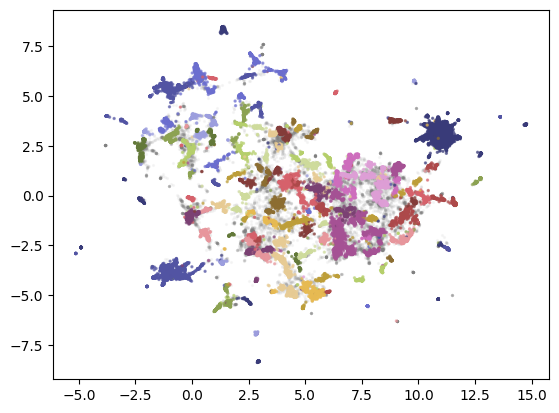

In [80]:
import matplotlib.pyplot as plt
plt.scatter(outliers.x,outliers.y,alpha=0.05,s=2,c="grey")
plt.scatter(to_plot.x,to_plot.y,alpha=0.6,s=2,c=to_plot.cluster.astype(int),cmap="tab20b")